**Adpoted from**: 
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [216]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn import metrics   #Additional scklearn functions

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

data = pd.read_csv('df_cleaned.csv').iloc[:,1:]
data.replace("APPROVED", 0, inplace=True)
data.replace("REJECTED", 1, inplace=True)
target = 'label'
predictors = [x for x in train.columns if x not in [target]][1:8]

In [230]:
X_train, X_test, y_train, y_test = train_test_split(data[predictors]\
                                                    , data[target], test_size=0.33, random_state=42)

In [231]:
train = X_train
train['label'] = y_train

In [232]:
test = X_test
test['label'] = y_test

In [233]:
train.groupby("label").size()

label
0    245
1     50
dtype: int64

In [235]:
test.groupby("label").size()

label
0    111
1     35
dtype: int64

## Fit Function

In [236]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['label'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Predict testing set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['label'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['label'], dtrain_predprob))
    print("AUC Score (Test): %f" % metrics.roc_auc_score(dtest['label'], dtest_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Step 1
**Fix learning rate and number of estimators** for tuning tree-based parameters

## XGB 1

[0]	train-auc:0.86488+0.01391	test-auc:0.87656+0.05659
[1]	train-auc:0.88842+0.02505	test-auc:0.88751+0.05436
[2]	train-auc:0.91162+0.01275	test-auc:0.88903+0.07019
[3]	train-auc:0.92803+0.01453	test-auc:0.90204+0.06078
[4]	train-auc:0.92849+0.01300	test-auc:0.90146+0.05430
[5]	train-auc:0.93040+0.01215	test-auc:0.90386+0.04987
[6]	train-auc:0.93594+0.00819	test-auc:0.90649+0.04641
[7]	train-auc:0.93834+0.00647	test-auc:0.90923+0.03855
[8]	train-auc:0.93993+0.00477	test-auc:0.91348+0.04077
[9]	train-auc:0.93915+0.00525	test-auc:0.90887+0.04467
[10]	train-auc:0.94009+0.00405	test-auc:0.91077+0.04324
[11]	train-auc:0.94104+0.00299	test-auc:0.91156+0.03986
[12]	train-auc:0.94417+0.00304	test-auc:0.91165+0.04389
[13]	train-auc:0.94641+0.00217	test-auc:0.91203+0.04348
[14]	train-auc:0.94628+0.00361	test-auc:0.90958+0.04411
[15]	train-auc:0.94702+0.00441	test-auc:0.91176+0.04366
[16]	train-auc:0.94933+0.00544	test-auc:0.91252+0.04407
[17]	train-auc:0.94943+0.00495	test-auc:0.91231+0.04702
[1

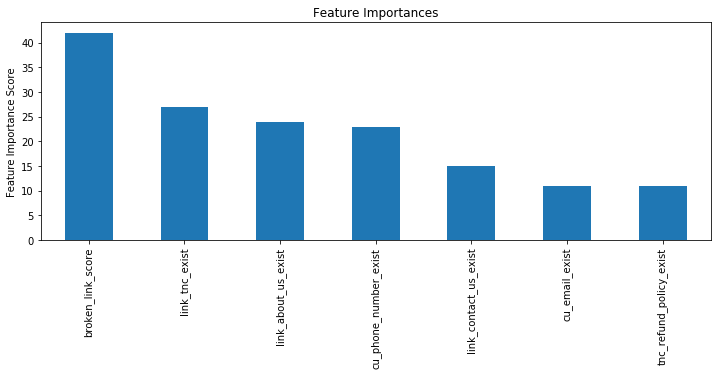

In [240]:
xgb1 = XGBClassifier(
     learning_rate=0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=27)
modelfit(xgb1, train, test, predictors)

## Step 2
Tune **max_depth** and **min_child_weight**

In [241]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=69, 
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27), 
    param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.best_params_, gsearch1.best_score_

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 3, 'min_child_weight': 5}, 0.9051020408163266)

The ideal values are 3 for max_depth and 5 for min_child_weight. 
Lets go one step deeper and look for optimum values. 
We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [242]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=69, 
    max_depth=3,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27), 
    param_grid = param_test2, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.best_params_, gsearch2.best_score_

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'max_depth': 3, 'min_child_weight': 5}, 0.9051020408163266)

It shows that the two params is changing its optimal values. Let's change the default param and recheck with higher values of **min_child_weight**.

In [244]:
param_test2b = {
 'min_child_weight':[6,8,10,12,14]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier(
    learning_rate =0.1, 
    n_estimators=69, 
    max_depth=3,
    min_child_weight=5,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27), 
    param_grid = param_test2b, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])
gsearch2b.best_params_, gsearch2b.best_score_

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'min_child_weight': 8}, 0.9083673469387754)

It changes again, assume that the current optimal values for params are:
    <br>
    **min_child_weight: 8**
    <br>
    **max_depth: 2**

## Step 3
Tune the **gamma** value with other param using the previous optimal ones

In [245]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=59, 
    max_depth=2,
    min_child_weight=8,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27), 
    param_grid = param_test3, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch3.fit(train[predictors], train[target])
gsearch3.best_params_, gsearch3.best_score_

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'gamma': 0.0}, 0.9067346938775511)

Gamma does not changes, it's good to re-callibrate the number of boosting rounds.

## XGB 2

[0]	train-auc:0.80985+0.00991	test-auc:0.81899+0.04350
[1]	train-auc:0.85017+0.02973	test-auc:0.84891+0.06241
[2]	train-auc:0.88689+0.03400	test-auc:0.85910+0.07031
[3]	train-auc:0.91154+0.01358	test-auc:0.87801+0.05136
[4]	train-auc:0.91168+0.01237	test-auc:0.88502+0.04599
[5]	train-auc:0.91474+0.01598	test-auc:0.89399+0.04102
[6]	train-auc:0.91739+0.01171	test-auc:0.90474+0.03854
[7]	train-auc:0.91648+0.01371	test-auc:0.90376+0.03854
[8]	train-auc:0.92098+0.00972	test-auc:0.90573+0.03896
[9]	train-auc:0.92019+0.01086	test-auc:0.90644+0.03931
[10]	train-auc:0.91996+0.00976	test-auc:0.90878+0.03490
[11]	train-auc:0.92223+0.00851	test-auc:0.91328+0.04038
[12]	train-auc:0.92277+0.00746	test-auc:0.91349+0.03978
[13]	train-auc:0.92301+0.00736	test-auc:0.91271+0.03767
[14]	train-auc:0.92305+0.00786	test-auc:0.91236+0.03872
[15]	train-auc:0.92411+0.00863	test-auc:0.91165+0.04245
[16]	train-auc:0.92260+0.00837	test-auc:0.90978+0.04577
[17]	train-auc:0.92242+0.00850	test-auc:0.90869+0.04446
[1

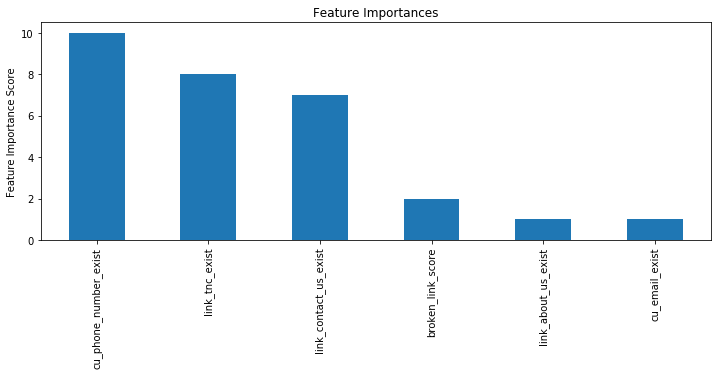

In [247]:
xgb2 = XGBClassifier(
 learning_rate=0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=8,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, test, predictors)

**max_depth:** 2<br>
**min_child_weight:** 8<br>
**gamma:** 0.0<br>
**n_estimators:** 61<br>

## Step 3
Tune the **subsample** and **colsample_bytree**

In [248]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=61, 
    max_depth=2,
    min_child_weight=8,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27), 
    param_grid = param_test4, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch4.fit(train[predictors], train[target])
gsearch4.best_params_, gsearch4.best_score_

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.9091836734693878)

Give another range of values for colsample_bytree with an interval of 0.05 since it's changing

In [251]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(85,95,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=61, 
    max_depth=2,
    min_child_weight=8,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.9,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27), 
    param_grid = param_test5, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch5.fit(train[predictors], train[target])
gsearch5.best_params_, gsearch5.best_score_

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'colsample_bytree': 0.9, 'subsample': 0.8}, 0.9091836734693878)

It stays, continue.

## Step 5
Tuning regularization for the model to reduce overfitting

In [258]:
param_test6 = {
 'reg_alpha':[0, 1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(
    learning_rate=0.1, 
    n_estimators=61, 
    max_depth=2,
    min_child_weight=8,
    gamma=0.0,
    subsample=0.8,
    colsample_bytree=0.9,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27), 
    param_grid = param_test6, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
gsearch6.fit(train[predictors], train[target])
gsearch6.best_params_, gsearch5.best_score_

c:\users\bahyh\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


({'reg_alpha': 0}, 0.9091836734693878)

## XGB 3

[0]	train-auc:0.80985+0.00991	test-auc:0.81899+0.04350
[1]	train-auc:0.85473+0.03543	test-auc:0.84838+0.06200
[2]	train-auc:0.89809+0.00265	test-auc:0.89663+0.02881
[3]	train-auc:0.90628+0.01256	test-auc:0.89691+0.02948
[4]	train-auc:0.90166+0.01491	test-auc:0.89198+0.03065
[5]	train-auc:0.90549+0.01514	test-auc:0.89996+0.03302
[6]	train-auc:0.90882+0.01109	test-auc:0.90771+0.03544
[7]	train-auc:0.91138+0.01347	test-auc:0.90006+0.04299
[8]	train-auc:0.91350+0.00880	test-auc:0.90166+0.04458
[9]	train-auc:0.91791+0.00600	test-auc:0.90431+0.04410
[10]	train-auc:0.92061+0.00784	test-auc:0.90966+0.03555
[11]	train-auc:0.92167+0.00819	test-auc:0.91700+0.03756
[12]	train-auc:0.92228+0.00643	test-auc:0.91629+0.03814
[13]	train-auc:0.92170+0.00701	test-auc:0.91629+0.03814
[14]	train-auc:0.92042+0.00826	test-auc:0.91371+0.03703
[15]	train-auc:0.92209+0.00775	test-auc:0.91212+0.04375
[16]	train-auc:0.92270+0.00647	test-auc:0.91252+0.04344
[17]	train-auc:0.92237+0.00726	test-auc:0.91482+0.03981
[1

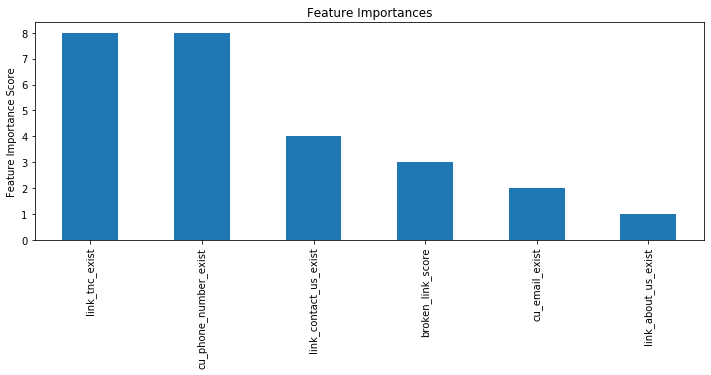

In [260]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=8,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, test, predictors)

## Step 6
Reduce the **learning_rate** and add more trees

## XGB 4

[0]	train-auc:0.80985+0.00991	test-auc:0.81899+0.04350
[1]	train-auc:0.85473+0.03543	test-auc:0.84838+0.06200
[2]	train-auc:0.88289+0.02842	test-auc:0.87163+0.06334
[3]	train-auc:0.88542+0.02984	test-auc:0.87315+0.06390
[4]	train-auc:0.88081+0.02761	test-auc:0.86822+0.06261
[5]	train-auc:0.89367+0.00424	test-auc:0.89216+0.03056
[6]	train-auc:0.89539+0.00704	test-auc:0.89534+0.03664
[7]	train-auc:0.89773+0.00696	test-auc:0.89641+0.03618
[8]	train-auc:0.90532+0.00756	test-auc:0.91282+0.03123
[9]	train-auc:0.90737+0.00749	test-auc:0.91396+0.03196
[10]	train-auc:0.90848+0.00594	test-auc:0.91409+0.02815
[11]	train-auc:0.90974+0.00549	test-auc:0.91376+0.02874
[12]	train-auc:0.91057+0.00588	test-auc:0.91492+0.02914
[13]	train-auc:0.91022+0.00594	test-auc:0.91523+0.03109
[14]	train-auc:0.91288+0.00470	test-auc:0.91220+0.03441
[15]	train-auc:0.91370+0.00465	test-auc:0.91352+0.03627
[16]	train-auc:0.91355+0.00502	test-auc:0.91503+0.03422
[17]	train-auc:0.91304+0.00469	test-auc:0.91503+0.03422
[1

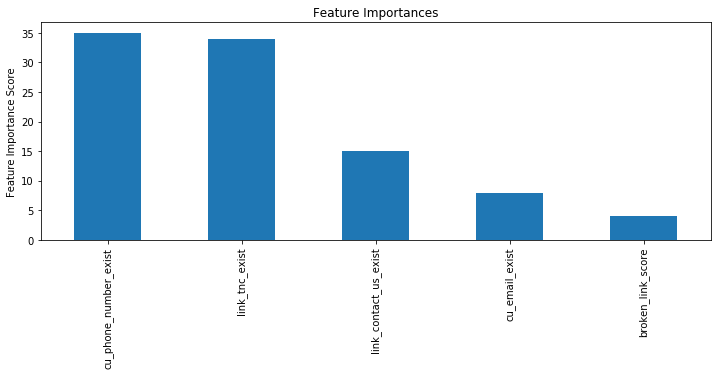

In [269]:
xgb4 = XGBClassifier(
 learning_rate=0.01,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=8,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, test, predictors)

Decreasing the learning rate **does not** make the model even better, so it should set back to default.<br>
Final params:<br>
     max_depth=**2**,<br>
     min_child_weight=**8**,<br>
     gamma=**0**,<br>
     subsample=**0.8**,<br>
     colsample_bytree=**0.9**<br>

In [271]:
## Extract Params
xgb3.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': None,
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 8,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 12,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': None,
 'validate_parameters': False,
 'verbosity': None,
 'nthread': 4,
 'seed': 27}